# Lab4.2 Testing and evaluating an emotion text classifier

Copyright: Vrije Universiteit Amsterdam, Faculty of Humanities, CLTL

In notebook Lab4.2, we analysed the training and test data and in Lab4.3, we tested the trained SVM classifier on the test set. The results were mixed, at least partly due to thedominance of the ```neutral``` class and partly due to underpresentation of emotions such as ```disgust``` and ```fear```.

In this notebook, we discuss anumber of adjustement that can be made to the classifier:

1. Adjusting the parameters for the CountVectorizer
2. Balancing the training data
3. Adjusting the parameters of the SVM classifier


## 1. Adjusting the parameters for the CountVectorizer

When we defined the CountVectorizer in Lab3, we have selected frequency thresholds for the Bag-of-Word representation of the text. We also analysed the vocabulary of the train and test data. Having more precise information about the frequency distributions of the tokens in the train and test set, we can inspect the vocabulary and make sure that words that we consider important for emotion detection are kept, whereas other words are removed.

This may force the classifier to use the words that matter and not lean so-called shortcuts that may work for this data but not for other data. Imagine that certain characters in the Friends sit.com are often sad. In that case the classifier may learn that mentioning this person in the utterance predicts the emotion ```sadness```. Obviously this will not work in other data.

We will not go further into demonstrating how this can be adjusted but leave this up to you to experiment with.

## 2. Balancing training data 

We have seen in notebook Lab4.3 that our system performs just above the baseline of the dominant class *neutral*: .47. What can you do if one class is so dominant?

Well, we can simply reduce the training data for the dominant class. The next code iterates over the rows in the dataframe and separately gets the utterance and label. To get the label that goes with the utterance, we need to pass the row index that goes with each utterance in the **iloc** function of the Emotion column. We use a general Python **enumerate** function to simultaneously get the utterance and the row index from the list of utterances in the Utterance column.

We first import the training data again.

In [30]:
filepath = '../Lab3.machine_learning/data/MELD/train_sent_emo.csv'
# Create a dataframe object 'dftrain' by readig the file.
dftrain = pd.read_csv(filepath)

In [31]:
## With sample we define how many training cases we want to skip to select the next training item
## If set to 5 we take 1 out of 5
sample = 5

balanced_training_instances=[]
balanced_training_labels=[]

cnt_neutral = 0
for row_nr, utterance in enumerate(dftrain['Utterance']):
    emotion_label = dftrain['Emotion'].iloc[row_nr] # this reads as from the column 'Emotion' take the value from the row located at 'row_nr'
    if emotion_label =='neutral':
        cnt_neutral += 1
        if cnt_neutral % sample == 0:  ### this checks if the count is dividable by the value of sample (no leftover)
            balanced_training_instances.append(utterance)
            balanced_training_labels.append(emotion_label)
    else:
        balanced_training_instances.append(utterance)
        balanced_training_labels.append(emotion_label)

In [32]:
balanced_df = pd.DataFrame(balanced_training_labels, columns = ['Emotion'])
print(balanced_df.info())
print(balanced_df.head(15))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6221 entries, 0 to 6220
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Emotion  6221 non-null   object
dtypes: object(1)
memory usage: 48.7+ KB
None
     Emotion
0   surprise
1    neutral
2       fear
3    neutral
4   surprise
5   surprise
6    sadness
7   surprise
8       fear
9    neutral
10       joy
11   sadness
12  surprise
13   disgust
14   sadness


In [33]:
import seaborn as sns

#### Adding proportions to plotted labels counts
def plot_labels_with_counts(labels, values):
    total = 0
    total = sum(values)
   # print('Total of values', total)
    ax = sns.barplot(x=labels, y=values)
    # Add values above bars
    for i, v in enumerate(values):
        ax.text(i, v + 0.2, str(int((v/total*100)))+'%', ha='center')
    plt.show()

['joy', 'surprise', 'anger', 'neutral', 'sadness', 'disgust', 'fear'] [1743, 1205, 1109, 942, 683, 271, 268]


/Users/piek/.pyenv/versions/3.10.11/lib/python3.10/site-packages/seaborn/_core.py:1485: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


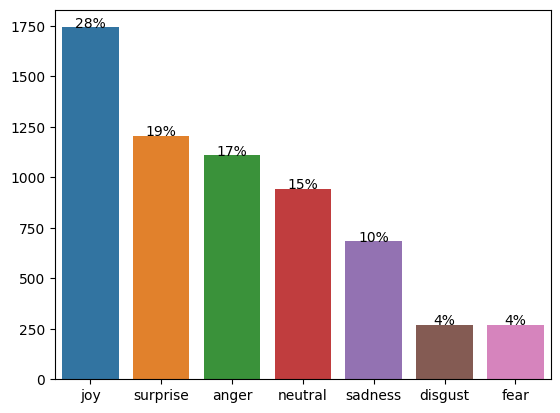

In [34]:
counts = balanced_df.Emotion.value_counts()
labels = counts.index.to_list()
values = counts.to_list()
print(labels, values)
plot_labels_with_counts(labels, values)

Will any of this work? To figure this out we need to retrain and test a new classifier with the new data.

### Rebuild the vectorizer and train a new model

In [38]:
import sklearn
import numpy
import nltk
from sklearn import svm
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
frequency_threshold = 5
utterance_vec =CountVectorizer(min_df=frequency_threshold, 
                             tokenizer=nltk.word_tokenize, 
                             stop_words=stopwords.words('english'))
training_count_vectors = utterance_vec.fit_transform(balanced_training_instances)
tfidf_transformer = TfidfTransformer()
training_tfidf_vectors = tfidf_transformer.fit_transform(training_count_vectors)
svm_linear_clf = svm.LinearSVC(max_iter=2000)
svm_linear_clf.fit(training_tfidf_vectors, balanced_training_labels)

/Users/piek/.pyenv/versions/3.10.11/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/piek/.pyenv/versions/3.10.11/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'m", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


LinearSVC(max_iter=2000)

## Load and represent the test data

In [43]:

import pandas as pd

filepath = '../Lab3.machine_learning/data/MELD/test_sent_emo.csv'
# Create a dataframe object 'dtest' by readig the file.
dftest = pd.read_csv(filepath)
dftest.info()
test_instances=dftest['Utterance']
test_labels = dftest['Emotion']
test_count_vectors = utterance_vec.transform(test_instances)
test_tfidf_vectors = tfidf_transformer.transform(test_count_vectors)
y_pred_svm = svm_linear_clf.predict(test_tfidf_vectors)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2610 entries, 0 to 2609
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Sr No.        2610 non-null   int64 
 1   Utterance     2610 non-null   object
 2   Speaker       2610 non-null   object
 3   Emotion       2610 non-null   object
 4   Sentiment     2610 non-null   object
 5   Dialogue_ID   2610 non-null   int64 
 6   Utterance_ID  2610 non-null   int64 
 7   Season        2610 non-null   int64 
 8   Episode       2610 non-null   int64 
 9   StartTime     2610 non-null   object
 10  EndTime       2610 non-null   object
dtypes: int64(5), object(6)
memory usage: 224.4+ KB


Balanced BoW TFIDF SVM LINEAR ----------------------------------------------------------------
              precision    recall  f1-score   support

       anger      0.256     0.261     0.259       345
     disgust      0.129     0.059     0.081        68
        fear      0.036     0.020     0.026        50
         joy      0.311     0.629     0.416       402
     neutral      0.751     0.447     0.561      1256
     sadness      0.240     0.236     0.238       208
    surprise      0.373     0.577     0.453       281

    accuracy                          0.430      2610
   macro avg      0.300     0.318     0.290      2610
weighted avg      0.507     0.430     0.439      2610

Confusion matrix SVM
['anger' 'disgust' 'fear' 'joy' 'neutral' 'sadness' 'surprise']
[[ 90   2   2 139  40  21  51]
 [ 14   4   2  15  16   5  12]
 [ 13   1   1  17   5   8   5]
 [ 32   5   2 253  55  20  35]
 [147  17  17 276 562  90 147]
 [ 36   2   3  50  46  49  22]
 [ 19   0   1  64  24  11 162]]


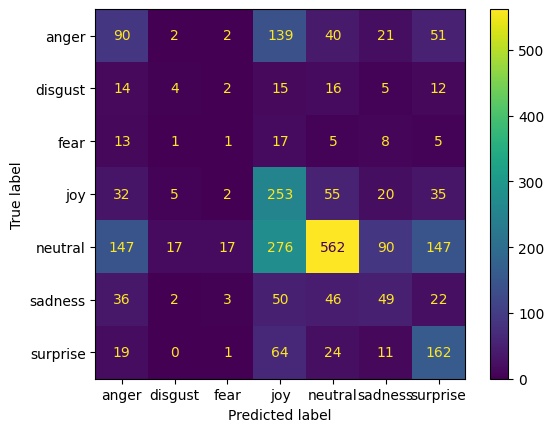

In [45]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

report = classification_report(test_labels,y_pred_svm,digits = 3, target_names = svm_linear_clf.classes_)
print('Balanced BoW TFIDF SVM LINEAR ----------------------------------------------------------------')
print(report)

print('Confusion matrix SVM')
print(svm_linear_clf.classes_)
cf_matrix_svm = confusion_matrix(test_labels,y_pred_svm)
print(cf_matrix_svm)
import matplotlib.pyplot as plt
display = ConfusionMatrixDisplay(confusion_matrix=cf_matrix_svm, display_labels=svm_linear_clf.classes_)
display.plot()

Did the results improve? Well, the results are different. For sure ```neutral``` is less dominant but the results for the other categories did not really improve a lot. Of course you could experiment with other thresholds for downsampling and see what happens.

One of the problems is that underrepresented categories can only be fixed with more data. So looking for other data sets may help, but realise that the data may also be very differetn fromt the test set.

## 3. Adjusting the parameters of the classifier

### 3.1 Balancing the class weight

Instead of downsampling dominant classes, Sklearn also provides an option to specify ```class weights``` when creating an instance of the classifier. If the data set is unbalanced, you can instruct the classifier to give more weight to underrepresented classes. The “balanced” mode automatically adjust weights inversely proportional to class frequencies in the input data.

Lets try this on the classifier we just trained with more balanced training data.

Balanced BoW TFIDF SVM LINEAR ----------------------------------------------------------------
              precision    recall  f1-score   support

       anger      0.283     0.238     0.258       345
     disgust      0.067     0.176     0.098        68
        fear      0.020     0.080     0.032        50
         joy      0.393     0.515     0.446       402
     neutral      0.754     0.453     0.566      1256
     sadness      0.196     0.260     0.224       208
    surprise      0.389     0.534     0.450       281

    accuracy                          0.413      2610
   macro avg      0.300     0.322     0.296      2610
weighted avg      0.520     0.413     0.444      2610

Confusion matrix SVM
['anger' 'disgust' 'fear' 'joy' 'neutral' 'sadness' 'surprise']
[[ 82  27  41  85  37  30  43]
 [ 10  12   7   6  19   5   9]
 [  9   4   4   8   8  12   5]
 [ 31  25  21 207  53  33  32]
 [108  81 100 142 569 127 129]
 [ 27  14  16  32  47  54  18]
 [ 23  15  10  47  22  14 150]]


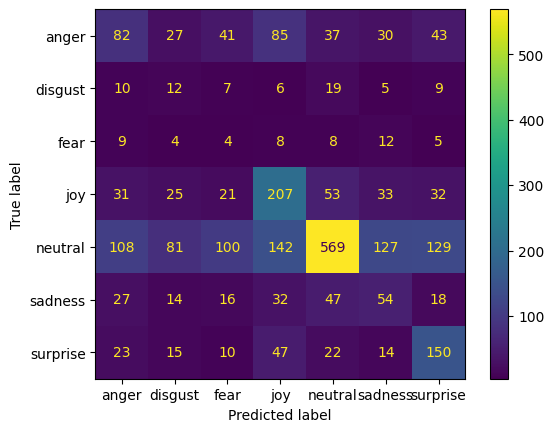

In [46]:
svm_linear_clf_balanced_weights = svm.LinearSVC(class_weight = "balanced", max_iter=2000)
svm_linear_clf_balanced_weights.fit(training_tfidf_vectors, balanced_training_labels)
y_pred_svm = svm_linear_clf_balanced_weights.predict(test_tfidf_vectors)


report = classification_report(test_labels,y_pred_svm,digits = 3, target_names = svm_linear_clf_balanced_weights.classes_)
print('Balanced BoW TFIDF SVM LINEAR ----------------------------------------------------------------')
print(report)

print('Confusion matrix SVM')
print(svm_linear_clf_balanced_weights.classes_)
cf_matrix_svm = confusion_matrix(test_labels,y_pred_svm)
print(cf_matrix_svm)
import matplotlib.pyplot as plt
display = ConfusionMatrixDisplay(confusion_matrix=cf_matrix_svm, display_labels=svm_linear_clf_balanced_weights.classes_)
display.plot()

### 3.2 Adjusting the C-value

Sklearn also has a regulation parameter for the C-value. This parameter balances the effort to maximize the margin between correct and incorrect cases over all the data and the penalty for any misclassification. In a SVM you are searching for two things: a hyperplane with the largest minimum margin, and a hyperplane that correctly separates as many instances as possible. The former makes sure that correct and incorrect cases are separated as far as possible, whereas the latter makes sure that outliers are also classified correctly. The problem is that you will not always be able to get both things and this depends on the data at hand.

The next image illustrates this.

<img src="images/c-value-1.png" width="300" height="400">

To the left you have a low c which gives you a pretty large minimum margin (purple). However, this requires that we neglect the blue circle outlier that we have failed to classify correct. On the right you have a high c. Now you will not neglect the outlier and thus end up with a much smaller margin. Depending on the data, a high or low value works better. In the next case a large value works best because a group correct cases gets included for a similar max margin:

<img src="images/c-value-2.png" width="300" height="400">

However, in the following case a low value works better because the smallest margin sacrifices only a single correct case:

<img src="images/c-value-3.png" width="300" height="400">

The default value for C is 1. If you have a lot of noisy observations you should decrease it: decreasing C corresponds to more regularization.
LinearSVC and LinearSVR are less sensitive to C when it becomes large, and prediction results stop improving after a certain threshold. Meanwhile, larger C values will take more time to train, sometimes up to 10 times longer: [See sklearn website for more details](https://scikit-learn.org/stable/modules/svm.html)

A higher C-value (100) forces the model to have more recall (try to include all cases), whereas a lower C-value (0.01) would make the system differentiate classes better and be more precise.

Credits to: https://www.geeksforgeeks.org/machine-learning/what-is-the-influence-of-c-in-svms-with-linear-kernel/

What is the influence of C in SVMs with linear kernel?

Support Vector Machines (SVMs) are powerful machine learning algorithms used for classification and regression tasks. When dealing with linearly separable data, SVMs use a linear kernel to find the optimal hyperplane that separates the classes. A crucial parameter in this process is C, which plays a significant role in shaping the decision boundary.

The parameter C in Support Vector Machines (SVMs) with a linear kernel controls the trade-off between the margin of the decision boundary and the accuracy of classifying the training data. Essentially, C determines how much the SVM should penalize misclassifications, influencing the complexity and accuracy of the model.

 A higher C value makes the model aim for fewer misclassifications by using a smaller margin, while a lower C allows more misclassifications with a wider margin.
How C Parameter in SVM Works?
The parameter C is a regularization parameter that balances two competing goals:

Maximizing the margin (the distance between the hyperplane and the nearest data points).
Minimizing the number of misclassifications in the training data.
Now, this is what c values convey:

High C Values: A high value of C means that the SVM will be heavily penalized for any misclassifications. This leads to a narrower margin, as the model will try to classify all training points correctly, even if it results in a more complex decision boundary. In practice, this can lead to overfitting, where the model performs well on the training data but poorly on new, unseen data.
Low C Values: Conversely, a low value of C means that the SVM will be less penalized for misclassifications. This results in a wider margin, leading to a simpler decision boundary. While this can reduce overfitting, it may also reduce the training accuracy, as some points may be misclassified to achieve a larger margin.

The next code demonstrates how varying the C value in an SVM model with an linear kernel affects decision boundaries and model accuracy. We generate synthetic data, train the model with different C values, and plot both the decision boundaries for each C and the corresponding accuracy on a log-scale graph. Lower C values result in smoother boundaries, favoring generalization, while higher C values create tighter boundaries, which may overfit.

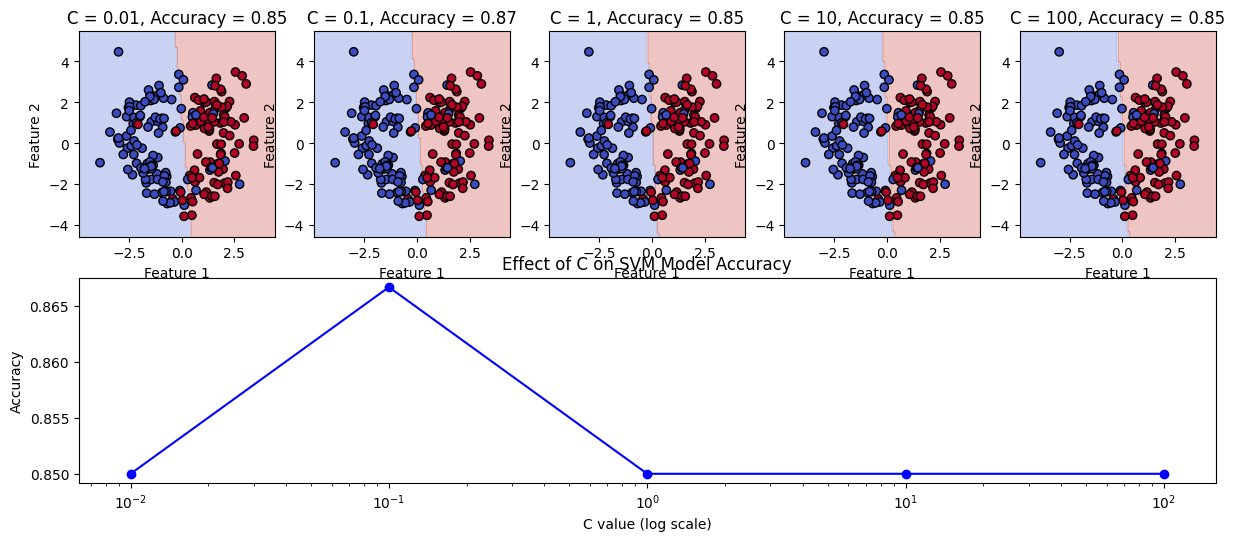

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Generate synthetic data (two classes)
X, y = datasets.make_classification(
    n_samples=200, n_features=2, n_informative=2, n_redundant=0, 
    n_clusters_per_class=2, flip_y=0.1, class_sep=1.5, random_state=42
)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define different C values to test
C_values = [0.01, 0.1, 1, 10, 100]

# Plotting setup
plt.figure(figsize=((1100/75), (1100/75)/2.5))

# Initialize list to store accuracies for plotting
accuracies = []

# Train and plot SVM for each C value
for i, C in enumerate(C_values, 1):
    # Initialize SVM model with Linear kernel and specified C value
    model = SVC(C=C, kernel='linear')
    model.fit(X_train, y_train)
    
    # Predict on test set and calculate accuracy
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    
    # Plot decision boundary
    plt.subplot(2, len(C_values), i)
    plt.title(f'C = {C}, Accuracy = {accuracy:.2f}')
    
    # Create a grid to plot decision boundary
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary and scatter plot of data points
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap='coolwarm')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

# Plot accuracies vs C values
plt.subplot(2, 1, 2)
plt.plot(C_values, accuracies, marker='o', linestyle='-', color='b')
plt.xscale('log')
plt.xlabel('C value (log scale)')
plt.ylabel('Accuracy')
plt.title('Effect of C on SVM Model Accuracy')
plt.savefig('Effect of C on SVM Model Accuracy.jpeg',bbox_inches='tight',dpi = 75)

As C increases (1, 10, and 100), the decision boundary becomes increasingly non-linear, with more bends and curves. This suggests that the SVM is attempting to fit the training data more precisely, even at the risk of overfitting. When C is small (0.01 and 0.1), the decision boundary is linear, indicating that the SVM is not trying to capture complex patterns in the data.

The accuracy of the model appears to be relatively stable across different values of C. The optimal value of C depends on the specific dataset and the desired trade-off between model complexity and accuracy. Cross-validation is a common technique to find the best C value by evaluating the model's performance on a validation set.

# End of this notebook